# Using the latest advancements in deep learning to predict stock price movements

## 1. 소개

주식 시장이 움직이는 것을 정확히 예측하는 것은 매우 어려운 일입니다. 주식이 특정 방향으로 움직이는 것은 수백만 개의 이벤트와 사전 조건이 존재하기 때문입니다. 그래서 우리는 이러한 사전 조건들을 capture해야합니다. 그러기 위해서 우리는 아래와 같은 가정들이 필요합니다.  <br>

><br>
__1) 시장은 100% random하지 않다.<br>
>2) 역사는 반복된다.<br>
>3) 시장은 사람들의 합리적인 행동에 따른다.<br>
>4) 시장은 'perfect'하다.<br>__
<br>


우리는 이러한 가정을 한 뒤,  `삼성전자(005930)` 의 주가 움직임을 예측해 볼 것입니다. __2010년 1월 1일__부터 __2018년 12월 31일__의 데이터를 사용할 것입니다. (7년은 training 목적, 2년은 validation 목적)<br>

***
## 2. 데이터

우리는 삼성전자의 주가가 등락 여부에 어떤 것들이 영향을 주는 지를 이해해야 합니다. 그러므로, 우리는 가능한 많은 정보 (주식을 다양한 방면과 각도로 묘사하는) 를 통합할 것입니다. 우리는 일별 데이터 (우리가 가지고 있는 데이터의 70%) 를 사용하여 다양한 알고리즘을 훈련시키고 나머지를 예측하는데 사용할 것입니다. 그리고 우리는 예측된 결과와 hold-out 데이터를 비교할 것입니다. 각각의 데이터는 후의 섹션에서 자세하게 설명할 것입니다. 간단하게 보자면 크게 우리가 사용할 features는 다음과 같습니다.

### 1. Correlated assets

이것들은 다른 자산입니다.(꼭 주식이 아니더라도 __원자재, FX, 지수, 채권__ 등 아무 유형) 삼성전자와 같은 큰 기업은 명백히 고립되어 살지않습니다. __외부 요인, 경쟁사를 포함하여 고객들, 글로벌 경제, 지정학적 현상, 재정 및 통화 정책, 자본 접근__ 등이 있습니다.

### 2. Technical indicators

많은 투자자들은 기술적 지표를 이용합니다. 우리는 가장 대중적인 지표를 독립적인 feature로 사용할 것입니다. 그 중에서도 __7일과 21일 이동 평균선, 지수 이동 평균선, 모멘텀, 볼린저 밴드, MACD__입니다.

### 3. Fundamental analysis

주가가 오를지 내릴지를 알려주는 아주 중요한 지표입니다. 기본적 분석에는 2가지 feature가 사용될 수 있습니다.

>__1) 연간보고서와 분기 보고서를 이용한 회사 실적 분석__<br> ROE와 P/E, 기타등등 <br><br>
>__2) 뉴스__ <br>잠재적으로 뉴스는 주가에 영향을 줄 이벤트를 알려줄 수 있습니다. 우리는 삼성전자의 일별 뉴스를 읽은 다음에 삼성전자에 대한 그날의 total sentiment가  positive, neutral, negative 에 따라 score를 매길 것입니다. 많은 투자자들이 뉴스를 읽고 투자에 대한 결정을 내리기 때문에 오늘 삼성전자에 대한 뉴스가 매우 긍정적이면 내일 주식이 급등할 가능성이 높습니다. 한가지 중요한 점은 이 기능을 포함하여 모든 기능을 수행한 뒤 이를 사용할 지 여부를 결정할 것입니다. 정확한 sentiment 예측을 위해 NLP(자연어처리)를 사용합니다.

In [2]:
import os
import sys
import pandas as pd
data_path = os.path.join(os.path.dirname(os.getcwd()), 'data')
sys.path.append(data_path)
from stock_db import stockDB
from company_list import CompanyList

In [3]:
stock_db = stockDB(path=data_path)
table = stock_db.get_code_table("ohlcv", "005930")
samsung_df = pd.DataFrame(table, columns=['symbol', 'date', 'open', 'high', 'low', 'close', 'volume'])

stock.db is loaded.


In [4]:
samsung_df = samsung_df.drop(['symbol'], axis=1).set_index('date')

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

plotly.offline.init_notebook_mode(connected=True)

In [6]:
train, test = train_test_split(samsung_df, test_size=0.3, shuffle=False)
print('There are {} number of days in the dataset.'.format(samsung_df.shape[0]))
print('train set : {}, test set : {}'.format(train.shape[0], test.shape[0]))
print('train period : {} ~ {}'.format(train.index[0], train.index[-1]))
print('test period : {} ~ {}'.format(test.index[0], test.index[-1]))

There are 2739 number of days in the dataset.
train set : 1917, test set : 822
train period : 2008-01-02 ~ 2015-09-16
test period : 2015-09-17 ~ 2019-01-25


In [7]:
trace_high = go.Scatter(
                x=samsung_df.index,
                y=samsung_df['close'],
                name = "close",
                line = dict(color = '#17BECF'),
                opacity = 0.8)
"""
trace_low = go.Scatter(
                x=df.index,
                y=df['low'],
                name = "Samsung Low",
                line = dict(color = '#7F7F7F'),
                opacity = 0.8)
"""
data = [trace_high]#,trace_low]

layout = dict(autosize=False,width=800, height=400, title = "Samsung stock price", titlefont = { "size": 11 },
              annotations=[dict(x=test.index[0], 
                                y=test.close[0], 
                                xref='x',
                                yref='y',
                                text='test_point',
                                showarrow=True,
                                arrowhead=7,
                                ax=0,
                                ay=-40
                                ),
                          ],
              shapes = [{
                        'type': 'rect',
                        'xref': 'x',
                        'yref': 'paper',
                        'x0': test.index[0],
                        'y0': 0,
                        'x1': test.index[-1],
                        'y1': 500000,
                        'fillcolor': '#d3d3d3',
                        'opacity': 0.2,
                        'line': {
                            'width': 0,}}],
             xaxis = dict(title = 'Date',  titlefont = { "size": 10 }),
             yaxis = dict(title = 'WON',  titlefont = { "size": 10 }))

    

fig = dict(data=data, layout=layout)
plotly.offline.iplot(fig, filename = "Samsung")

# 2.1. Correlated assets

앞서 설명했듯이 삼성전자뿐 아니라 다른 자산들을 feature로 사용할 것입니다.<pr><pr>
    어떤 자산들이 삼성전자의 주가 움직임에 영향을 미칠까요? __기업, 기업의 비지니스, 경쟁구도, 의존성, 공급업체 및 고객 유형__ 등을 잘 이해하는 것은 상관 관계가 있는 자산을 올바르게 선택하는데 매우 중요합니다.


* 먼저 삼성전자와 유의미한 상관관계를 갖고 있는 기업들을 찾아볼 것입니다.

In [60]:
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool
import matplotlib.pyplot as plt
import numpy as np

get_ipython().magic('matplotlib inline')

In [61]:
company_list = CompanyList().read_company_list(path=data_path)

전체 주가 데이터를 symbol을 column으로 하여  데이터프레임을 생성한 뒤 데이터를 입력합니다.

In [62]:
all_df = pd.DataFrame(index=train.index)

In [63]:
with tqdm(total=company_list.shape[0]) as pbar:
    for index, row in company_list.iterrows():
        code = row.종목코드
        table = stock_db.get_code_table("ohlcv", code)
        df = pd.DataFrame(table, columns=['symbol', 'date', 'open', 'high', 'low', code, 'volume']).set_index('date')
        all_df = all_df.join(df[code])
        pbar.update(1)

이제 특정 기업과 나머지 모든 기업에 대한 correlation을 구합니다.

In [180]:
def search_string(gr, column, strings_list):
    """
    search for a string in a dataframe specified in columns
    """
    if isinstance(strings_list,str):
        strings_list = [strings_list]
    if isinstance(column, str):
        #### if column is not a list but a string, it means there is only one column to search
        return gr[gr[column].str.contains('|'.join(strings_list),na=False)]
    else:
        gr_df = pd.DataFrame()
        counter = 0
        for col in column:
            if counter == 0:
                gr_df =  gr[gr[col].str.contains('|'.join(strings_list),na=False)]
                counter += 1
            else:
                gr_df.append(gr[gr[col].str.contains('|'.join(strings_list),na=False)])
                counter += 1
        return gr_df

    
def top_correlation_to_name(stocks, column_name, searchstring, top=10, abs_corr=False):
    """
    This function draws a correlation chart of the top "x" rows of a data frame that are
    highly correlated to a selected row in the dataframe. You can think of the rows of the
    input dataframe as containing stock prices or fund flows or product sales and the columns
    should contain time series data of prices or flows or sales over multiple time periods.
    Now this program will allow you to select the top 5 or 10 rows that are highly correlated
    to a given row selected by the column: column_name and using a search string "searchstring". The
    program will search for the search string in that column column_name and return a list of 5 or 10
    rows that are the most correlated to that selected row. If you give "top" as a float ratio
    then it will use the ratio as the cut off point in the correlation coefficient to select rows.
    """
    incl = [x for x in list(stocks) if x not in column_name]
    ### First drop all NA rows since they will mess up your correlations.
    stocks.dropna(inplace=True)
    ### Now find the highest correlated rows to the selected row ###
    try:
        index_val = search_string(stocks, column_name,searchstring).index[0]
    except:
        print('Not able to find the search string in the column.')
        return
    ### Bring that selected Row to the top of the Data Frame
    df = stocks[:]
    df["new"] = range(1, len(df)+1)
    df.loc[index_val,"new"] = 0
    stocks = df.sort_values("new").drop("new",axis=1)
    stocks.reset_index(inplace=True,drop=True)
    ##### Now calculate the correlation coefficients of other rows with the Top row
    try:
        if abs_corr == True:
            cordf = pd.DataFrame(stocks[incl].T.corr().abs().sort_values(0,ascending=False))
        else:
            cordf = pd.DataFrame(stocks[incl].T.corr().sort_values(0,ascending=False))
    except:
        print('Cannot calculate Correlations since Dataframe contains string values or objects.')
        return
    try:
        cordf = stocks[column_name].join(cordf)
    except:
        cordf = pd.concat((stocks[column_name],cordf),axis=1)
    #### Visualizing the top 5 or 10 or whatever cut-off they have given for Corr Coeff
    if top >= 1:
        top10index = cordf.sort_values(0,ascending=False).iloc[:top,:3].index
        top10names = cordf.sort_values(0,ascending=False).iloc[:top,:3][column_name]
        top10values = cordf.sort_values(0,ascending=False)[0].values[:top]
    else:
        top10index = cordf.sort_values(0,ascending=False)[
            cordf.sort_values(0,ascending=False)[0].values>=top].index
        top10names = cordf.sort_values(0,ascending=False)[
            cordf.sort_values(0,ascending=False)[0].values>=top][column_name]
        top10values = cordf.sort_values(0,ascending=False)[
            cordf.sort_values(0,ascending=False)[0].values>=top][0]
    #### Now plot the top rows that are highly correlated based on condition above
    stocksloc = stocks.iloc[top10index]
    #### Visualizing using Matplotlib ###
    stocksloc = stocksloc.T
    stocksloc = stocksloc.reset_index(drop=True)
    stocksloc.columns = stocksloc.iloc[0].values.tolist()
    stocksloc.drop(0).plot(subplots=True, figsize=(15,10),legend=False,
                         title="Top %s Correlations to %s" %(top,searchstring))
    [ax.legend(loc=1) for ax in plt.gcf().axes]
    plt.tight_layout()
    plt.show()
    
    return dict(zip(top10names, top10values))

In [161]:
all_df_T = all_df.T
all_df_T.reset_index(drop=False, inplace=True)
all_df_T.head(1)

date,index,2008-01-02,2008-01-03,2008-01-04,2008-01-07,2008-01-08,2008-01-09,2008-01-10,2008-01-11,2008-01-14,...,2015-09-03,2015-09-04,2015-09-07,2015-09-08,2015-09-09,2015-09-10,2015-09-11,2015-09-14,2015-09-15,2015-09-16
0,001040,74211.0,73551.0,72420.0,71477.0,71854.0,72608.0,72137.0,71194.0,71665.0,...,256958.0,249886.0,258844.0,275346.0,263559.0,276760.0,296563.0,259787.0,258844.0,252715.0


In [162]:
excl = ['index']
incl = [x for x in list(all_df_T) if x not in excl]
for col in incl:
    all_df_T[col] = all_df_T[col].map(lambda x: float(x))

date   index  2008-01-02  2008-01-03  2008-01-04  2008-01-07  2008-01-08  \
0     001040     74211.0     73551.0     72420.0     71477.0     71854.0   
1     011150      1305.0      1305.0      1315.0      1275.0      1295.0   
3     001390      8440.0      8170.0      8090.0      8080.0      8190.0   
4     010060    235000.0    244000.0    280500.0    280500.0    271000.0   
5     002360       796.0       792.0       793.0       786.0       789.0   
6     001740     21600.0     21900.0     21650.0     21200.0     21350.0   
8     011810   6495264.0   6609119.0   6633461.0   6527719.0   6430266.0   
9     024070      3967.0      3932.0      3932.0      3879.0      3879.0   
10    011420      6350.0      6500.0      6600.0      6790.0      6840.0   
12    002240     18918.0     19344.0     19193.0     19143.0     19344.0   
13    001290      4490.0      4588.0      4579.0      4615.0      4846.0   
14    014530      1090.0      1090.0      1065.0      1080.0      1065.0   
15    013700

[1059 rows x 1918 columns]


C:\Anaconda\envs\py36_32\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Anaconda\envs\py36_32\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



0       005930
482     001800
419     030000
1039    090460
1021    054050
383     000430
732     091120
817     084370
541     002840
605     023910
Name: index, dtype: object [1.         0.94809816 0.93687365 0.92024943 0.91436686 0.91177298
 0.91086538 0.90686765 0.9066721  0.90565385]


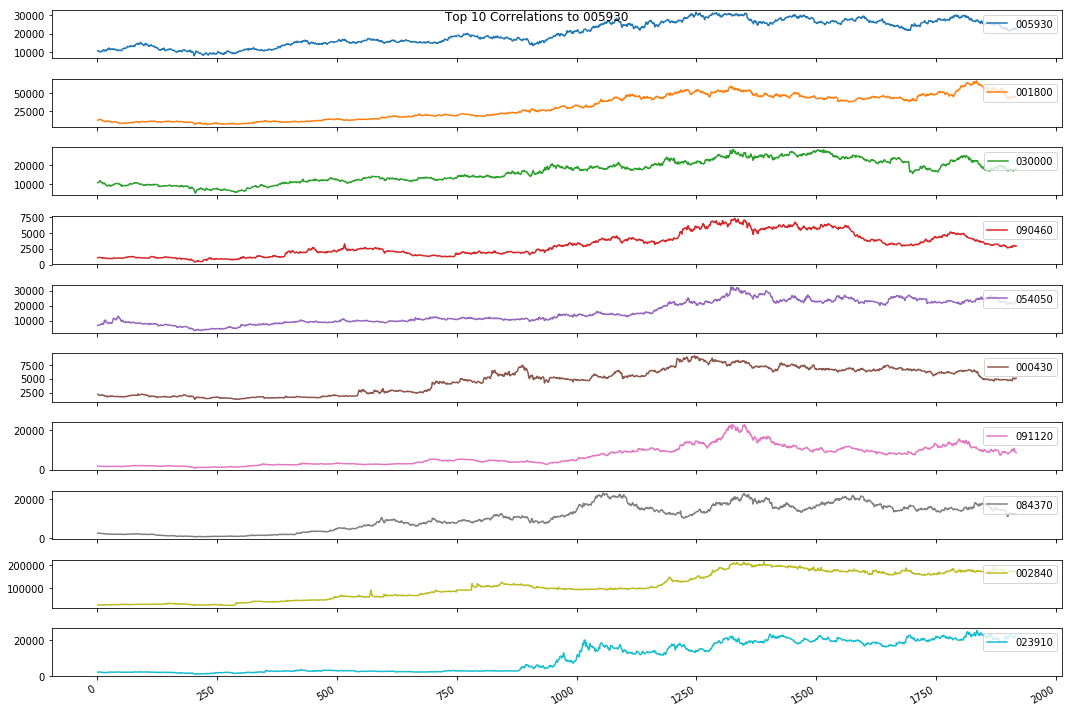

In [163]:
top_correlated_companies = top_correlation_to_name(all_df_T, 'index', '005930', 10, abs_corr=True)

유의미한 상관관계를 가지는 종목은 아래와 같은 결과가 나왔습니다. 

In [107]:
for key, value in top10.items():
    print('{} : {}'.format(company_list.loc[company_list.종목코드 == key, '회사명'].values[0], value))   

삼성전자 : 1.0
오리온홀딩스 : 0.9480981638541061
제일기획 : 0.9368736502664881
비에이치 : 0.9202494270558285
농우바이오 : 0.9143668553498088
대원강업 : 0.9117729811664602
이엠텍 : 0.9108653829283581
유진테크 : 0.9068676514545693
미원상사 : 0.906672100249667
대한약품 : 0.9056538452345098
대창단조 : 0.9042256938562423
모다이노칩 : 0.9028987455871256
동원산업 : 0.8986331098780933
코리아써키트 : 0.8976065658501795
빙그레 : 0.8974202698070239
신풍제약 : 0.8944000687762138
롯데푸드 : 0.8877023057883933
가비아 : 0.886249882855033
제낙스 : 0.885522265658661
세코닉스 : 0.8852867431550218


위 목록에 대한 놀라운 사실은 __오리온 홀딩스__가 삼성그룹 계열사보다 __삼성전자__와 더 관련이 있다는 것입니다. 이것을 더 자세히 조사해 봅시다.


위와 같은 주식 차트처럼 "trendy"한 시계열 데이터에 대한 것 중 하나는 오해의 소지가 있는 결론으로 이어질 수 있습니다.

각 차트는 시간과 관련이 있기 때문에 한 주식 차트가 다른 차트에 대해 회귀 할 때 주가와 같은 "trendy"한 시계열 데이터가 까다로울 수 있습니다. 그들은 모두 시간과 상관 관계가 있기 때문에 강하지만, 종종 가짜 관계를 나타낼 것입니다.

따라서 __주가__와 같은 __"trendy"한 시계열 데이터__는 __"nonstationary"__로 간주됩니다.(즉, 시간에 따라 변화하는 평균 및 분산을 갖는 것)

그렇기 때문에 시계열 데이터를 처리 할 때 당신은 일반적으로 그들이 시간에 독립적으로 상관 관계가 있는지 알고 싶어할 것입니다. 한 series의 variations이 다른 것의 variations과 일치 하는지 여부를 알고 싶을 겁니다. 이 때, "Trend"의 존재는 당신을 혼동시킬 수 있으므로 피해야합니다.

따라서 데이터에서 "trend"을 제거하기 위해 다음의 작업을 수행했습니다.

먼저 __전체 시계열을 1의 기간으로 차이__를 두었습니다. 이것은 지난 기간동안 포트폴리오에서 모든 "일일 수익률"을 얻었음을 의미합니다. 우리는 이제 삼성전자의 일일 수익률과 가까운 correlation을 갖는 종목들로 비교할 것입니다.

우리의 데이터 프레임에 적용된 "diff (1)"함수로 pandas에서 이것을 쉽게 수행 할 수 있습니다. 우리는 기존의 주식 포트폴리오에서 differnce를 하도록 하겠습니다. .

In [168]:
all_df_diff = all_df.diff(1)
all_df_diff = all_df_diff.iloc[1:,:]
all_df_diff_T = all_df_diff.T
all_df_diff_T.reset_index(drop=False, inplace=True)

In [171]:
excl = ['index']
incl = [x for x in list(all_df_diff_T) if x not in excl]
for col in incl:
    all_df_diff_T[col] = all_df_diff_T[col].map(lambda x: float(x))

C:\Anaconda\envs\py36_32\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Anaconda\envs\py36_32\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



0      005930
329    009150
227    000660
72     034220
176    016360
371    066570
512    005380
540    006800
302    003550
57     005490
29     006400
224    005940
40     055550
363    004020
175    010140
313    008060
573    086790
372    051910
380    000270
583    009540
Name: index, dtype: object [1.         0.40658399 0.37512303 0.36649794 0.35648432 0.35136664
 0.34865663 0.34234541 0.33449729 0.33170556 0.32994654 0.3263557
 0.32482192 0.3214825  0.30589143 0.30530295 0.29084082 0.28961423
 0.28667224 0.28634892]


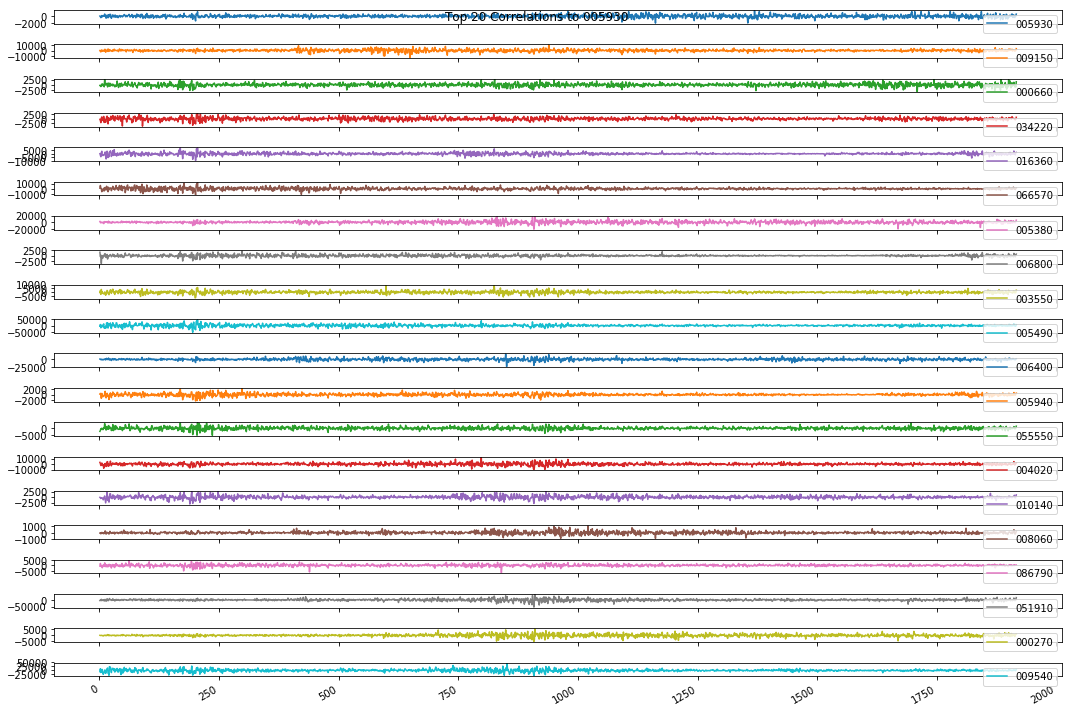

In [178]:
top_correlated_companies = top_correlation_to_name(all_df_diff_T, 'index', '005930', 20, abs_corr=True)

In [179]:
for key, value in top_correlated_companies.items():
    print('{} : {}'.format(company_list.loc[company_list.종목코드 == key, '회사명'].values[0], value))   

삼성전자 : 1.0
삼성전기 : 0.4065839894458186
SK하이닉스 : 0.3751230260001406
LG디스플레이 : 0.36649793644842443
삼성증권 : 0.35648431858304086
LG전자 : 0.3513666375750098
현대자동차 : 0.3486566349968074
미래에셋대우 : 0.34234540952567116
LG : 0.3344972856664867
포스코 : 0.33170556252036365
삼성SDI : 0.3299465382745211
NH투자증권 : 0.3263556970235145
신한지주 : 0.32482192179633407
현대제철 : 0.3214824955861261
삼성중공업 : 0.3058914250927514
대덕전자 : 0.3053029492646008
하나금융지주 : 0.290840817339199
LG화학 : 0.28961422868991915
기아자동차 : 0.2866722425207029
현대중공업 : 0.28634891643901533


새로운 차트의 흥미로운 점은 이전보다 삼성전자와의 상관관계가 훨씬 낮다는 것입니다. "trend"를 제거했음에도 불구하고 상관관계가 있는 종목들을 보면 매우 다른 결과입니다. 삼성의 계열사가 주를 이루고 관련되어 있는 종목들이 결과로 나오는 것을 확인할 수 있었습니다. 

이 간단한 tool을 통해서 우리는 상관관계가 있는 종목들을 도출해 낼 수 있었습니다. 시계열의 데이터에서 얻을 수 있는 "trend"가 있는 데이터는 분명히 차이를 둬야된다는 것을 알 수가 있었습니다.

***

## Reference

https://medium.com/@ram.seshadri/drawing-top-5-or-10-correlated-stocks-to-the-one-you-own-using-python-c2c9f3aedc01